# 로지스틱 회귀의 독립변수 보고

## #01. 준비작업

### [1] 패키지 가져오기

In [28]:
import warnings
warnings.filterwarnings(action='ignore')

from helper.util import *
from helper.plot import *
from helper.analysis import *
from helper.classification import *

# 로지스틱 회귀 통계 모형
from statsmodels.api import Logit, add_constant
# 확률밀도함수
from scipy.stats import norm
import numpy as np

### [2] 데이터 가져오기

오렌지와 자몽의 지름, 무게, 색상 데이터

> https://www.kaggle.com/datasets/joshmcadams/oranges-vs-grapefruit

| 변수 | 설명 |
|---|---|
| name | 종속변수. `orange`, `grapefruit` |
| diameter | 지름(센티미터) |
| weight | 무게(그램) |
| red | RGB 스캔의 평균 빨간색 판독값(`0~255`) |
| green | RGB 스캔의 평균 녹색 판독값(`0~255`) |
| blue | RGB 스캔의 평균 파란색 판독값(`0~255`) |

In [29]:
origin = my_read_excel("https://data.hossam.kr/mldata/citrus.xlsx", categories=['name'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      10000 non-null  category
 1   diameter  10000 non-null  float64 
 2   weight    10000 non-null  float64 
 3   red       10000 non-null  int64   
 4   green     10000 non-null  int64   
 5   blue      10000 non-null  int64   
dtypes: category(1), float64(2), int64(3)
memory usage: 400.6 KB
None

데이터프레임 상위 5개 행
+----+--------+------------+----------+-------+---------+--------+
|    | name   |   diameter |   weight |   red |   green |   blue |
|----+--------+------------+----------+-------+---------+--------|
|  0 | orange |       2.96 |    86.76 |   172 |      85 |      2 |
|  1 | orange |       3.91 |    88.05 |   166 |      78 |      3 |
|  2 | orange |       4.42 |    95.17 |   156 |      81 |      2 |
|  3 | orange |       4.47 |     95.6 |   163 |      81 |      4 |
|  4 | orange |   

> 데이터의 군집 비율은 5000개로 모두 균일하고 각 피쳐의 평균과 중앙값이 큰 차이가 없는 것으로보아 모든 변수들이 정규분포를 따른다.

## #02. 탐색적 데이터 분석

### [1] 상자그림

데이터 분포 확인

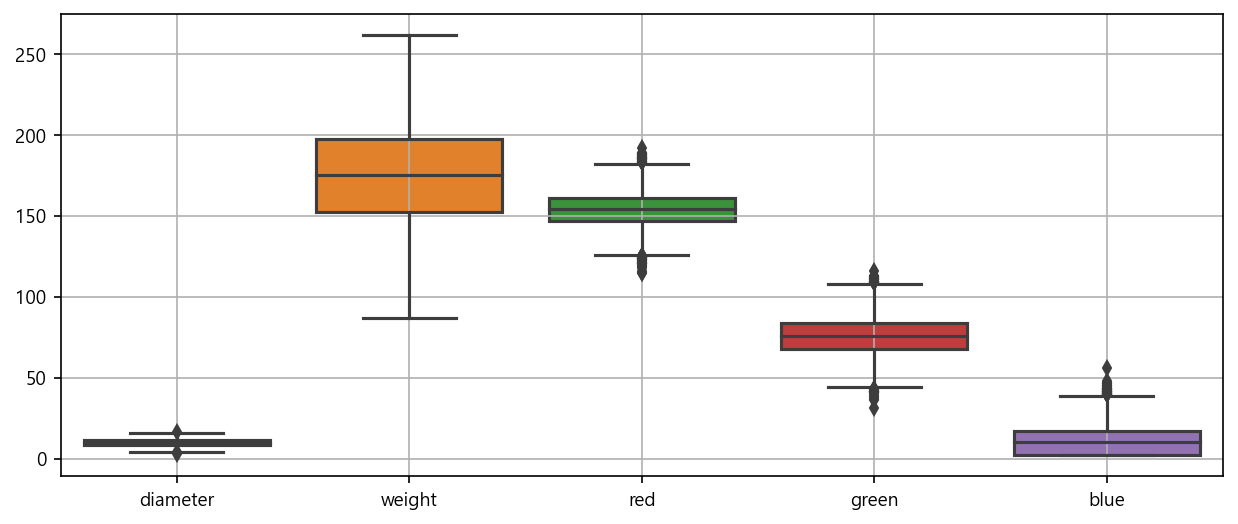

In [30]:
my_boxplot(origin)

> 데이터 스케일링이 시급해 보인다.

## #03. 데이터 전처리

### [1] 데이터 스케일링

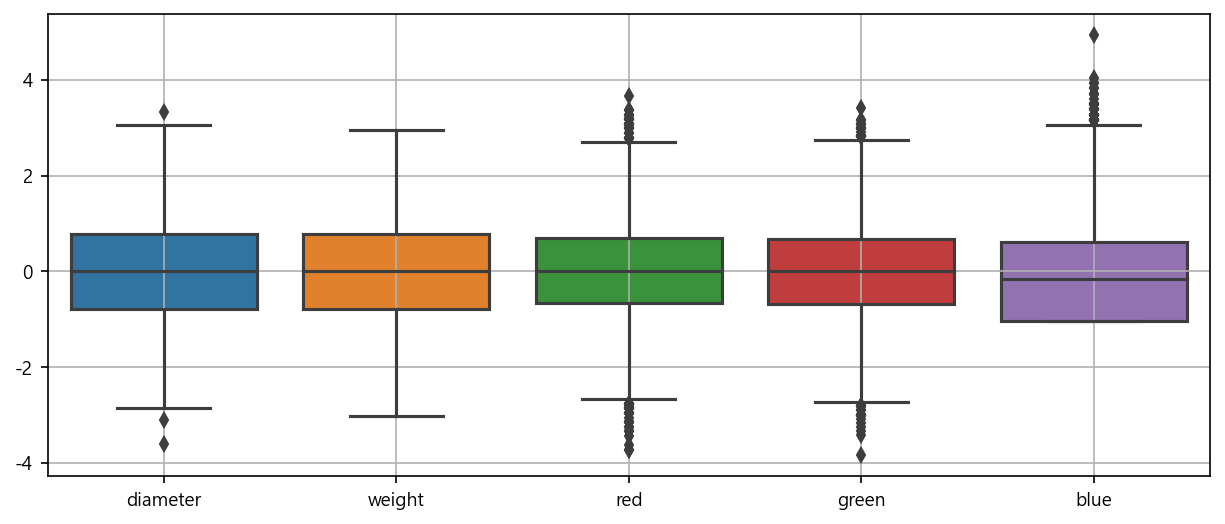

In [31]:
df = my_standard_scaler(origin, yname='name')
my_boxplot(df)

> 이상치를 처리하지 않은 경우와 이상치를 처리한 경우의 성능을 비교하는 것이 맞지만 여기서는 이상치 정제는 생략

### [2] 데이터 라벨링

로지스틱 회귀의 종속변수는 반드시 `0`, `1`로 구분된 정수형 이진값으로 구성되어야 한다.

> util.py 파일에 `my_labelling()`함수를 구현

In [32]:
df2 = my_labelling(df, "name")
my_pretty_table(df2.head())

+----+------------+----------+----------+-----------+-----------+--------+
|    |   diameter |   weight |      red |     green |      blue |   name |
|----+------------+----------+----------+-----------+-----------+--------|
|  0 |   -3.60195 | -3.02255 |  1.73998 |   0.76781 |  -1.03337 |      1 |
|  1 |   -3.11421 | -2.97839 |  1.16485 |   0.16992 | -0.923007 |      1 |
|  2 |   -2.85237 | -2.73465 | 0.206299 |  0.426159 |  -1.03337 |      1 |
|  3 |    -2.8267 | -2.71992 | 0.877283 |  0.426159 | -0.812642 |      1 |
|  4 |   -2.82156 | -2.71445 | 0.685574 | -0.342557 | -0.260815 |      1 |
+----+------------+----------+----------+-----------+-----------+--------+


## #04. statsmodels 패키지를 활용한 로지스틱 분석

In [33]:
y = df2['name']
x = df2.drop('name', axis=1)

model = Logit(y, add_constant(x))
fit = model.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.116766
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                   name   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Tue, 05 Mar 2024   Pseudo R-squ.:                  0.8315
Time:                        10:41:40   Log-Likelihood:                -1167.7
converged:                       True   LL-Null:                       -6931.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9649      0.077     12.538      0.000       0.814       1.116
diameter     -53.4531      2

In [54]:
# 오즈비 계산
np.exp(fit.params)

const       2.624640e+00
diameter    6.103857e-24
weight      1.346120e+21
red         1.778590e+00
green       3.585955e+00
blue        3.364885e-01
dtype: float64

## #05 sklearn 을 활용한 로지스틱 분석

### [1] 분석 모형 만들기

statsmodels 패키지는 하이퍼파라미터가 `C=100` 이상의 큰 값을 사용한다. (최적 하이퍼 파라미터 지정 불가)

statsmodels 내부의 소수점 처리 연산 과정에서 소수점 3째 자리 정도의 오차는 발생한다.

statsmodels와 같은 결과값을 만드는 것이 목표이므로 훈련/검증 데이터 분할 없이 모든 데이터를 훈련용으로 사용

[교차검증]
+----+-----+-------------------+
|    |   C |   mean_test_score |
|----+-----+-------------------|
|  0 | 100 |            0.8732 |
+----+-----+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 | 설명                                                      |
|-------------------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.831305 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |       0.9628 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision)       |     0.977704 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)          |       0.9472 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout)       |       0.0216 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)             |       0.9784 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score           

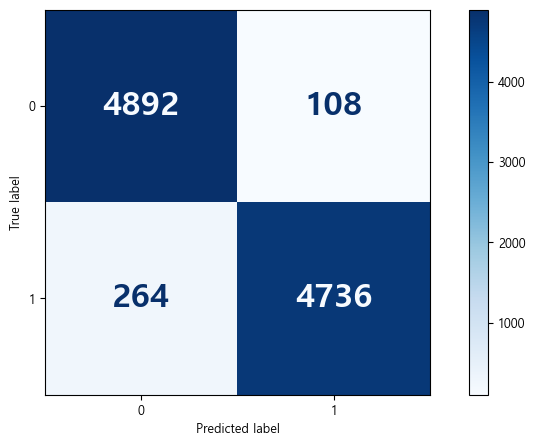


[ROC/PR Curve]


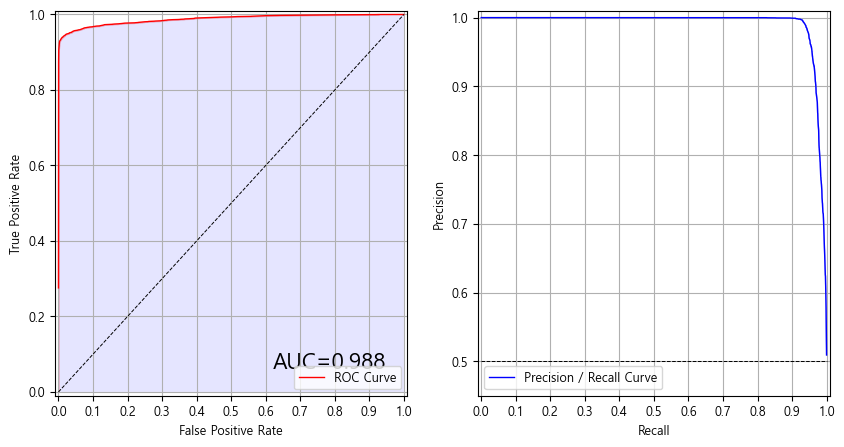


[학습곡선]


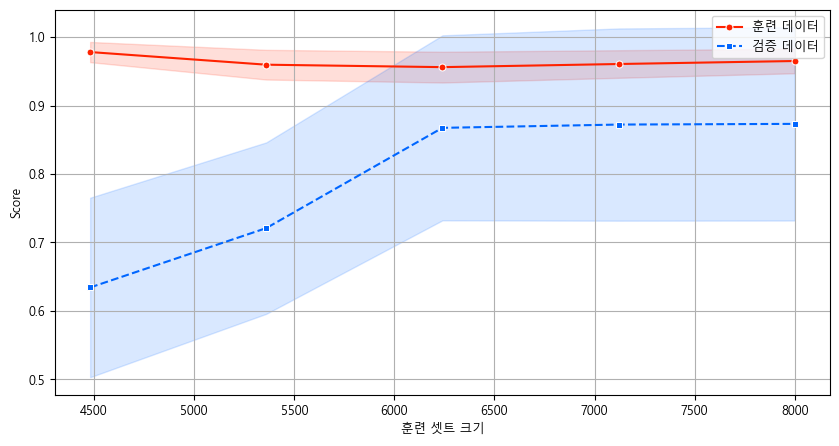

+----+------------+------------+--------------------+------------+----------+------------+-------------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |        t |   유의확률 |    OddsRate |
|----+------------+------------+--------------------+------------+----------+------------+-------------|
|  0 | name       | diameter   |           -49.7423 |      1.959 | -25.3929 |          0 | 2.49571e-22 |
|  1 | name       | weight     |            45.0508 |      1.905 |  23.6548 |          0 | 3.67548e+19 |
|  2 | name       | red        |             0.5688 |      0.057 |   10.065 |          0 |     1.76615 |
|  3 | name       | green      |             1.2603 |      0.068 |  18.6694 |          0 |     3.52648 |
|  4 | name       | blue       |            -1.0738 |      0.066 | -16.2419 |          0 |    0.341708 |
+----+------------+------------+--------------------+------------+----------+------------+-------------+


LogisticRegression(C=100, max_iter=500, n_jobs=-1)

In [34]:
estimator = my_logistic_classification(x_train=x, y_train=y, params={"C": [100]})
estimator

### [2] 절편

In [35]:
estimator.intercept_

array([0.88442138])

In [36]:
print("%0.4f" % estimator.intercept_[0])

0.8844


### [3] 회귀계수

In [37]:
estimator.coef_

array([[-49.74228518,  45.05080545,   0.56884299,   1.26025785,
         -1.07380954]])

In [38]:
estimator.feature_names_in_

array(['diameter', 'weight', 'red', 'green', 'blue'], dtype=object)

In [39]:
for i, v in enumerate(estimator.feature_names_in_):
    print("%s: %0.4f" % (v, estimator.coef_[0][i]))

diameter: -49.7423
weight: 45.0508
red: 0.5688
green: 1.2603
blue: -1.0738


### [4] 추정확률

In [40]:
y_pred_proba = estimator.predict_proba(x)
y_pred_proba

array([[0.00000000e+00, 1.00000000e+00],
       [6.34272634e-11, 1.00000000e+00],
       [5.43110223e-10, 9.99999999e-01],
       ...,
       [9.99999931e-01, 6.91928967e-08],
       [9.99999999e-01, 9.95609037e-10],
       [1.00000000e+00, 6.77505048e-14]])

### [5] 추정확률의 길이 (=샘플수)

In [41]:
n = len(y_pred_proba)
n

10000

### [6] 계수의 수 + 1(절편)

In [42]:
m = len(estimator.coef_[0]) + 1

### [7] 절편과 계수를 하나의 배열로 결합

In [43]:
coefs = np.concatenate([estimator.intercept_, estimator.coef_[0]])
coefs

array([  0.88442138, -49.74228518,  45.05080545,   0.56884299,
         1.26025785,  -1.07380954])

### [8] 상수항 추가

In [44]:
x_full = np.matrix(np.insert(np.array(x), 0, 1, axis=1))
print(x_full)

[[ 1.         -3.60195018 -3.02255396  1.73997781  0.76780981 -1.03337209]
 [ 1.         -3.11420697 -2.978392    1.16484825  0.16992022 -0.92300682]
 [ 1.         -2.85236589 -2.73464536  0.20629897  0.42615862 -1.03337209]
 ...
 [ 1.          2.88246734  2.78833864  1.3565581   0.51157142  0.95320276]
 [ 1.          3.05189393  2.91295068 -1.13567001 -0.34255657 -0.04008467]
 [ 1.          3.32400329  2.95985137 -0.17712073 -0.17173097 -1.03337209]]


### [9] 변수의 길이를 활용하여 모든 값이 0인 행렬 생성

In [45]:
ans = np.zeros((m, m))
ans

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

### [10] 표준오차

In [46]:
for i in range(n):
    ans += np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * y_pred_proba[i,1] * y_pred_proba[i, 0]

vcov = np.linalg.inv(np.matrix(ans))
se = np.sqrt(np.diag(vcov))
se

array([0.07310741, 1.9589031 , 1.90451095, 0.05651681, 0.06750408,
       0.06611339])

### [11] T값

In [47]:
t =  coefs/se  
t

array([ 12.09756208, -25.39292793,  23.65478947,  10.06502357,
        18.66935923, -16.24193721])

### [12] p-value

In [48]:
p_values = (1 - norm.cdf(abs(t))) * 2
p_values

array([0., 0., 0., 0., 0., 0.])

### [13] Odds Rate (오즈비)

오즈비는 성공할 확룰을 실패할 확률로 나눈 값

계수값에 대해 np.exp() 함수를 적용하면 각각의 회귀계수들을 오즈값으로 변환할 수 있다.

In [49]:
np.exp(estimator.coef_[0])

array([2.49574397e-22, 3.67549819e+19, 1.76622234e+00, 3.52633065e+00,
       3.41704299e-01])

### [14] 결과표 생성

In [55]:
xnames = estimator.feature_names_in_

result_df = DataFrame({
    "종속변수": [y.name] * len(xnames),
    "독립변수": xnames,
    "B(비표준화 계수)": np.round(estimator.coef_[0], 4),
    "표준오차": np.round(se[1:], 3),
    "t": np.round(t[1:], 4),
    "유의확률": np.round(p_values[1:], 3),
    "OddsRate" : np.round(np.exp(estimator.coef_[0]), 4)
})

my_pretty_table(result_df)

+----+------------+------------+--------------------+------------+----------+------------+------------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |        t |   유의확률 |   OddsRate |
|----+------------+------------+--------------------+------------+----------+------------+------------|
|  0 | name       | diameter   |           -49.7423 |      1.959 | -25.3929 |          0 |          0 |
|  1 | name       | weight     |            45.0508 |      1.905 |  23.6548 |          0 | 3.6755e+19 |
|  2 | name       | red        |             0.5688 |      0.057 |   10.065 |          0 |     1.7662 |
|  3 | name       | green      |             1.2603 |      0.068 |  18.6694 |          0 |     3.5263 |
|  4 | name       | blue       |            -1.0738 |      0.066 | -16.2419 |          0 |     0.3417 |
+----+------------+------------+--------------------+------------+----------+------------+------------+


## #06. 모듈화 기능 확인

In [51]:
my_classification_report(estimator, x, y)

+----+------------+------------+--------------------+------------+----------+------------+-------------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |        t |   유의확률 |    OddsRate |
|----+------------+------------+--------------------+------------+----------+------------+-------------|
|  0 | name       | diameter   |           -49.7423 |      1.959 | -25.3929 |          0 | 2.49571e-22 |
|  1 | name       | weight     |            45.0508 |      1.905 |  23.6548 |          0 | 3.67548e+19 |
|  2 | name       | red        |             0.5688 |      0.057 |   10.065 |          0 |     1.76615 |
|  3 | name       | green      |             1.2603 |      0.068 |  18.6694 |          0 |     3.52648 |
|  4 | name       | blue       |            -1.0738 |      0.066 | -16.2419 |          0 |    0.341708 |
+----+------------+------------+--------------------+------------+----------+------------+-------------+
